
# Bayesian Hierarchical drift-diffusion modelling: A primer
Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com


This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Cavanagh et al.(2011) as an example.This dataset had been used in Wiecki et al (2013).


## About the dataset
### Participants
14 patients with Parkinsons' disease. 12 males, 2 females, age range (46 ~ 77 years).

### Experimental design

Two within-subject design: 
Independent variable: DBS on vs DBS off;
Independent variable: high (win-win; lose-lose) vs. low conflict (win-lose).

Dependent variable:
RT and response.

### Procedure

![Task dynamics](./Cavanagh_2011_procedure.png)

The above figure is from Cavanagh et al (2011)'s figure 1b. The experiment include two session: training and test. During training, participants learned to choose one item in each pair (termed A/B and C/D) that was reinforced more often (A/B, 100%/0%; C/D, 75%/25%). In example below, the butterfly might be A and the piano might be B. During testing, participants had to choose the better stimulus, leading to high-conflict choices for win-win (A/C) and lose-lose (B/D) as well as low-conflict choices (A/D, C/B). For example, if the cake was C in training, this would reflect a high-conflict win-win cue.

Only the testing data are available and used here in this primer.

**Reference of the data**

Cavanagh, J. F., Wiecki, T. V., Cohen, M. X., Figueroa, C. M., Samanta, J., Sherman, S. J., & Frank, M. J. (2011). Subthalamic nucleus stimulation reverses mediofrontal influence over decision threshold. Nature Neuroscience, 14(11), 1462–1467. https://doi.org/10.1038/nn.2925

Wiecki, T. V., Sofer, I., & Frank, M. J. (2013). HDDM: Hierarchical Bayesian estimation of the Drift-Diffusion Model in Python. Frontiers in Neuroinformatics, 7. https://doi.org/10.3389/fninf.2013.00014

## Step 1: Install HDDM

Here we will check the version of the package to make sure that HDDM works.

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

# set the color of plots
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


In [2]:
# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redefined import _parents_to_random_posterior_sample
from post_pred_gen_redefined import _post_pred_generate
from post_pred_gen_redefined import post_pred_gen

from pointwise_loglik_gen import _pointwise_like_generate
from pointwise_loglik_gen import pointwise_like_gen

### Loading data and explore the data

The data is from `HDDM` package itself, but it was hidden in the `examples` folder, uncomment the following code to find it out:

In [3]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)
# !head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

In [4]:
data = hddm.load_csv(os.path.join(os.path.dirname(hddm.__file__), 
                                  'examples', 
                                  'cavanagh_theta_nn.csv'))
data.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


### Check the number of trials for each condition

Way 1: grouped by `stim`

In [5]:
data.groupby(['subj_idx']).size()

subj_idx
0     298
1     298
2     293
3     255
4     283
5     303
6     299
7     294
8     293
9     217
10    309
11    305
12    267
13    274
dtype: int64

In [6]:
data.groupby(['subj_idx', 'stim', 'dbs']).size()

subj_idx  stim  dbs
0         LL    0      36
                1      37
          WL    0      74
                1      77
          WW    0      38
                       ..
13        LL    1      39
          WL    0      62
                1      73
          WW    0      32
                1      39
Length: 84, dtype: int64

Way 2: grouped by `conf`

In [7]:
data.groupby(['subj_idx', 'conf', 'dbs']).size()

subj_idx  conf  dbs
0         HC    0      74
                1      73
          LC    0      74
                1      77
1         HC    0      70
                1      75
          LC    0      77
                1      76
2         HC    0      77
                1      69
          LC    0      78
                1      69
3         HC    0      68
                1      58
          LC    0      71
                1      58
4         HC    0      73
                1      66
          LC    0      75
                1      69
5         HC    0      77
                1      71
          LC    0      77
                1      78
6         HC    0      75
                1      70
          LC    0      78
                1      76
7         HC    0      75
                1      77
          LC    0      69
                1      73
8         HC    0      73
                1      72
          LC    0      73
                1      75
9         HC    0      57
                1 

## Step 2: Visualize the raw data

Way 1: Original way

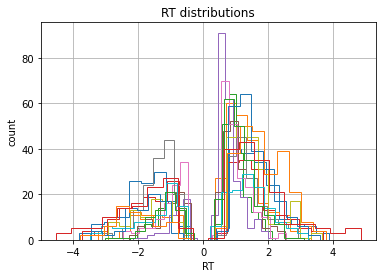

In [8]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Way 2: Interactive with plotly

### Visualize the summary results
Here we can reproduce part of Figure 3 in Cavanagh et al. (2011).

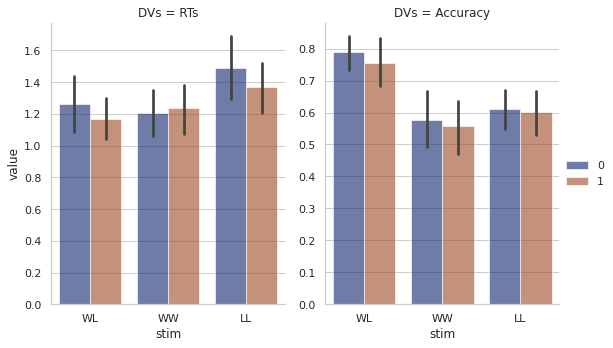

In [9]:
# get the median of accurate RTs
data_rt_sum = data[data['response'] ==1].groupby(['subj_idx','dbs', 'stim'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
data_acc_sum = data.groupby(['subj_idx','dbs', 'stim'])['response'].mean().reset_index()

data_rt_sum['DVs'] = 'RTs'
data_rt_sum.rename(columns={'rt':'value'}, inplace=True)
data_acc_sum['DVs'] = 'Accuracy'
data_acc_sum.rename(columns={'response':'value'}, inplace=True)

data_sum = pd.concat([data_rt_sum, data_acc_sum]).reset_index(drop=True)  # concat two dataframes

# # categorize the cond and order the data
from pandas.api.types import CategoricalDtype

stim_type = CategoricalDtype(categories=['WL', 'WW', 'LL'],
                           ordered=True)
data_rt_sum['stim'] = data_rt_sum['stim'].astype(stim_type)
data_acc_sum['stim'] = data_acc_sum['stim'].astype(stim_type)
data_sum['stim'] = data_sum['stim'].astype(stim_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=data_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='stim', y="value", hue = 'dbs', 
                #order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

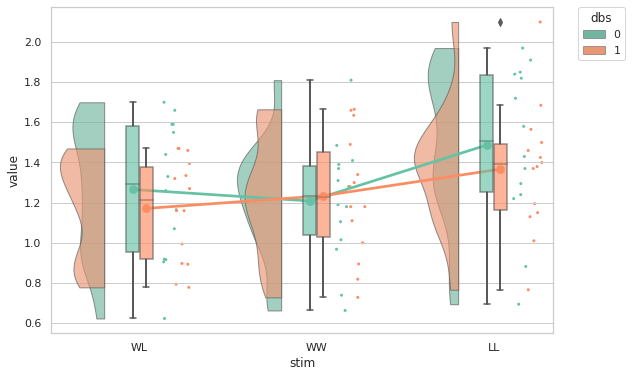

In [10]:
# plot raincloud of RT
import ptitprince as pt

dx = "stim"; dy = "value"; dhue = "dbs"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

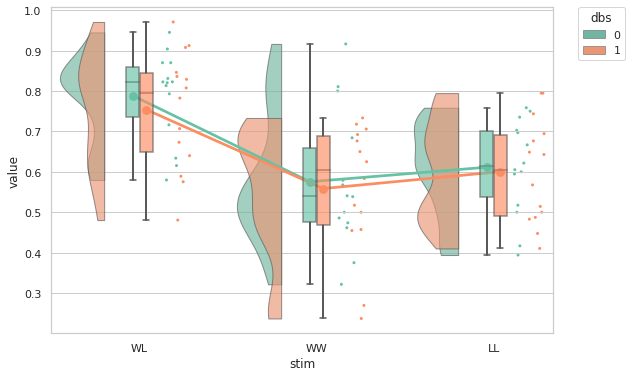

In [11]:
f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

In [12]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, 
#                                ncols=2, 
#                                figsize=(12, 6),
#                                sharex=True,
#                                sharey=False)

# ax1 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# ax2 = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_acc_sum, palette=pal, 
#                   bw=sigma, width_viol=.5,
#                   ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

# plt.show()

## Step 3: Prior predictive check

See `HDDM_Primer_SM_Prior_Check.ipynb`

## Step 4: Model specification

Model specification is for demonstration purpose.

Here we used models that already showed in previous tutorial, but with more details.

### M0: Baseline model: simplified model

In this model, we only fit a basic hierarchical DDM model, we assume that all the parameters are not varied across any condition.

`m0_0 = HDDM(data)`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z = 0.5 $$
$$sv = 0 $$
$$st = 0 $$
$$sz = 0 $$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

### M1: Baseline model: full model

`m1 = HDDM(data, include=['z', 'sv', 'sz', 'st'])`

$$x_{ij} \sim wfpt(a_j, v_j, t_j, z_j, sv, st, sz)$$
$$v_j \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

A graphical representation of this model is simpler than the graph appeared in [Wiecki et al, 2013](https://github.com/hddm-devs/hddm/blob/master/docs/paper/graphical_hddm.svg)):

![Graph_m0](./model_graphs/model_graph_basic.svg)


### M2: Depends_on conflict level, full model
In this model, we will use different `v` for different conflict levels, but keep all the other variables' at group level. By doing so, we added one additional level to the model ---- conditions. And this level has two levels: high vs. low. However, for the prior distribution, $v_{j, p}$ share the same priors.

`m2 = HDDM(data, depends_on={'v': 'conf'}, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} \sim N(\mu_v, \sigma_v^2)$$
$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$

[Insert graph of m1 here]

### M3: Regressed on conflict level (varying intercept)
In regression models, HDDM can be viewed as a hierarchical generalized linear model. Thus, experiences with generalized hierarchical linear model can be useful.

In previous tutorial, Wiecki et al (2011) demonstrated how to use regression model using `dummy coding` or `treatment coding`. There are also other coding schema available in `patsy`


`m3 = HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=True, include = ['z', 'sv', 'sz', 'st'])`

$$x_{i, k, j} \sim wfpt(a_j, v_{k, j}, t_j, z_j, sv, st, sz)$$

$$v_{k, j} = v_{j_{intercept}} + v_{k_{beta}} * Treatment_k$$

$$v_{j_{intercept}} \sim N(\mu_v, \sigma_v^2)$$
$$v_{k_{beta}} \sim N()$$

$$a_j \sim G(\mu_a, \sigma_a^2)$$
$$t_j \sim N(\mu_t, \sigma_t^2)$$
$$z_j \sim invlogit(N(\mu_z, \sigma_z^2))$$
$$sv \sim HN(2)$$
$$st \sim HN(0.3)$$
$$sz \sim B(1, 3)$$

$$ \alpha_v \sim N(\mu_v, \sigma_v^2)$$
$$ \beta_v \sim N()$$

$$\mu_a \sim G(1.5, 0.75)$$
$$\sigma_a \sim HN(0.1)$$

$$\mu_v \sim N(\mu = 2, \sigma = 3)$$
$$\sigma_v \sim HN(2)$$

$$\mu_z \sim N(0.5, 0.5)$$
$$\sigma_z \sim HN(0.05)$$

$$\mu_t \sim G(0.4, 0.2)$$
$$\sigma_t \sim HN(1)$$


* Contrast vs. variable. In Statistical rethings (page 157, 159), Richard distinguished `indicator variable` and `index variable` and recommended `index variable`. What is the relationship between these two and different contrast (design matrix)?

Now we need to have a bit tour on `patsy`. `patsy` used the grammar that may familiar to those who use `lme4` or related packages (e.g., `brms`).

Very briefly, the grammar of `patsy` is like this:

$$ y \sim a + b*x$$

The left hand side of $\sim$ is the variable need to be predicted, which is usually the outcome (i.e., parameters of DDM in HDDM). the right hand side of the $\sim$ is the predictors. please see the [document of `patsy`](https://patsy.readthedocs.io/en/latest/formulas.html) for more, or see https://arxiv.org/abs/1911.08628 for a more general explanation for MLM.

In `patsy`, the function`dmatrices` can give the design matrix with both the dependent variable on the lefthand side of the formual and the right hand side of the formula, which two parts are delimiited by `~` .

If we are only interested in the right hand side of the formula, which is we usually do, we need `dmatrix`.

As mentioned in `patsy` API, `patsy` has implemented several widely-used way to handle categorical data. 

The most-widely used one is "treatment contrast". 

The `reduced rank` and `full rank` are not familiar to readers from psychology. `redcued rank` is the design matrix with `intercept`, i.e., one level of the condition is selected as a reference. This `reduced rank` is the traditional meaning of `dummy coding` in psychology. `full rank` is the design without a reference, the each column of the resulting matrix represents the mean of the corresponding level. This way of coding is the call `cell mean` . 

In [13]:
from patsy import dmatrix, demo_data
demo = demo_data("a", "b", "x1", "x2", "y", "z column")

In [14]:
dmatrix("x1 + x2", demo)

DesignMatrix with shape (8, 3)
  Intercept        x1        x2
          1   1.76405  -0.10322
          1   0.40016   0.41060
          1   0.97874   0.14404
          1   2.24089   1.45427
          1   1.86756   0.76104
          1  -0.97728   0.12168
          1   0.95009   0.44386
          1  -0.15136   0.33367
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)

In [15]:
# show first 20 row of design matrix
dmatrix("C(conf, Treatment('LC'))", data.head(20))

# or using DataFrame:
#pd.DataFrame(dmatrix("C(conf, Treatment('LC'))", data))

DesignMatrix with shape (20, 2)
  Intercept  C(conf, Treatment('LC'))[T.HC]
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               0
          1                               1
          1                               1
          1                               0
          1                               0
          1                               1
          1                               0
          1                               0
          1                               0
  Terms:
    'Intercept' (column 0)
    "C(c

### M4: Regressed on conflict level (varying intercept and varying slope)

```
m3 = hddm.HDDMRegressor(data, "v ~ C(conf, Treatment('LC'))", group_only_regressors=False)
```

### M5: Using theta as an additional predictor of `a`
```
m4 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC'))",
                        depends_on={'v': 'conf'})
```

### M6: Regression for both parameters
```
m6 = hddm.HDDMRegressor(data[data.dbs == 0],
                        "a ~ theta:C(conf, Treatment('LC')),
                         v ~ C(conf, Treatment('LC'))")
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

### M7: Regression for three parameters

In the tutorial, Cavanagh modelled dbs on and off separately, can we model them in one model?

```
m7 = hddm.HDDMRegressor(data[data.dbs == 0],
     ["a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0')),
     v ~ C(conf, Treatment('LC'))"])
```

Two issues that persisted in the users' forum:
* Should we use `HDDMRegressor` whenever the design is within-subject?
* Do we need to start from the `full model` as suggested by some articles on linear mixed model?

In [16]:
pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data)).head()

,0,1,2,3,4
0,1.0,0.0,0.0,0.656275,0.000000
1,1.0,-0.0,-0.0,-0.000000,-0.327889
2,1.0,-0.0,-0.0,-0.480285,-0.000000
3,1.0,0.0,0.0,0.000000,1.927427
4,1.0,-0.0,-0.0,-0.213236,-0.000000


In [17]:
pd.DataFrame(dmatrix("0 + theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", data))

,0,1,2,3
0,0.000000,0.000000,0.656275,0.000000
1,-0.000000,-0.000000,-0.000000,-0.327889
2,-0.000000,-0.000000,-0.480285,-0.000000
3,0.000000,0.000000,0.000000,1.927427
4,-0.000000,-0.000000,-0.213236,-0.000000
...,...,...,...,...
3983,-1.237166,-0.000000,-0.000000,-0.000000
3984,-0.000000,-0.377450,-0.000000,-0.000000
3985,-0.000000,-0.694194,-0.000000,-0.000000
3986,-0.546536,-0.000000,-0.000000,-0.000000


## Step 5: Simulation, parameter recovery, and model recovery

See `HDDM_Primer_SM_Params_Recov.ipynb`


## Step 6: Model estimation with real data
We used parallel processing by `p_tqdm`.

In [18]:
%%time

# define a function to run model in parallel

# M0_0: base model: simplified
def run_m0(id, df=None, samples=None, burn=None, save_name="ms0"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M1: base model: full model
def run_m1(id, df=None, samples=None, burn=None, save_name="ms1"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M2: treat within-subj as between-subj: full model
def run_m2(id, df=None, samples=None, burn=None, save_name="ms2"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def run_m3(id, df=None, samples=None, burn=None, save_name="ms3"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def run_m4(id, df=None, samples=None, burn=None, save_name="ms4"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M5: regression model + theta as an additional predictor of `a`
def run_m5(id, df=None, samples=None, burn=None, save_name="ms5"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDMRegressor(df,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'conf'},
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M6: Regression for both parameters
def run_m6(id, df=None, samples=None, burn=None, save_name="ms6"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M7: Regression for both parameters
def run_m7(id, df=None, samples=None, burn=None, save_name="ms7"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


Here we define a function to run the model, get posterior, generate posterior predictive, and calculate the point-wise log likelihood. The steps inside can be executed separately too.

Note, I recommend users to run the modelling part using python script directly instead of in jupyter notebook.

`python -W ignore Run_all_models.py --samples 15000 --burn 7000 --nppc 1000 --chains 4 --test 0 --save 1`

In [19]:
samples = 25000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 10000     
nppc = 1000     # 1000 samples for posterior predictive, super slow
thin = 3
chains = 4
test_mode = False

In [20]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
    model_func = [run_m7]
    m_keys = ["ms0"]
    models = {"ms0": []}
    InfData = {"ms0": []} 

else: 
    model_func = [run_m0, run_m1, run_m2, run_m3, 
                  run_m4, run_m5, run_m6, run_m7]
    m_keys = ["ms0", "ms1", "ms2",
              "ms3", "ms4", "ms5",
              "ms6", "ms7"]
    
    models = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

    InfData = {"ms0": [], "ms1": [], "ms2": [], 
          "ms3": [], "ms4": [], "ms5": [], 
          "ms6": [], "ms7": []} 

for ii in range(len(model_func)):
    
    key = m_keys[ii]
    
    ####------------------ fitting the model or loading model object ------------------
    file_full_path = file_path + "/" + m_keys[ii] + "_tmp1_chain_*[!db]" 
    file_names = glob.glob(file_full_path, recursive=False)
    print(file_names)
    
    if file_names:
        for jj in file_names:
            print('current loading: ', jj, '\n')
            models[m_keys[ii]].append(hddm.load(jj))
    else:
        print('current estimating:', m_keys[ii])
        models[m_keys[ii]] = p_map(partial(model_func[ii], df=data, samples=samples, 
                                         burn=burn),
                                 range(chains))
    
    ####------------------ Getting posterior samples  --------------------------------
    trace_tmp = []
    df_traces_tmp = []
    for jj in range(len(models[m_keys[ii]])):
        trace_tmp = models[m_keys[ii]][jj].get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        df_traces_tmp.append(trace_tmp)
    df_traces_tmp = pd.concat(df_traces_tmp)
   
    ####------------------ Getting posterior predictives -----------------------------
    df_ppc_tmp = []
    ftr_path = file_path + "df_" + key + "_tmp1_ppc_chain_*ftr" 
    ftr_names = glob.glob(ftr_path, recursive=False)

    # if there are ftr files
    if ftr_names:
        print("Got feather file names, loading the PPC")
        for ftrname in ftr_names:
#             for f_id in range(len(ftr_names)):
            print("loading \n", ftrname)
            df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
            df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
            df_ppc_tmp.append(df_tmp)     
    else:
        print("No feather files either, run PPC now ...")
        print("Generating PPC ", key, "for", m_keys[ii])
        start_time = time.time()  # the start time of the processing
        df_ppc_tmp = p_map(partial(post_pred_gen, samples = nppc), models[m_keys[ii]])
        print("Running PPC costs %f seconds" % (time.time() - start_time))
        print("Save PPC to feather files")
        for chain in range(len(df_ppc[key])):
            ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
#             print(ftrname)
            df_ppc_tmp[chain].reset_index().to_feather(ftrname)
     
    ####------------------ Getting pointwise log likelihood ------------------------
    df_pll_tmp = []
    ftr_path = file_path + "df_" + key + "_tmp1_pll_chain_*ftr" 
    ftr_names = glob.glob(ftr_path, recursive=False)

    if ftr_names:
        print("Got feather file names, loading the loglik files")
        for ftrname in ftr_names:
            print("loading \n", ftrname)
            df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
            df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
            df_pll_tmp.append(df_tmp)
    else:
        print("No feather files either, run loglik now ...")

        ms = models[m_keys[ii]]
        print("Generating loglik ", key, "for", m_keys[ii])
        start_time = time.time()  # the start time of the processing
        # df_pll[m_keys[ii]] = p_map(partial(pointwise_like_gen, samples = 500), ms)
        df_pll_tmp = p_map(partial(pointwise_like_gen), ms)

        print("Generating loglik costs %f seconds" % (time.time() - start_time))

        print("Save loglik to feather files")
        for chain in range(len(df_pll[key])):
            ftrname = file_path + "df_" + key + "_tmp1_pll_chain_" + str(chain) + ".ftr"
            print(ftrname)
            df_pll_tmp[chain].reset_index().to_feather(ftrname)
    
    ####------------------ Getting pointwise log likelihood ------------------------
    #     for ii in range(len(models)):
    obs_data = models[key][0].data.copy()
    obs_data.index.names = ['trial_idx']
    
    if 'conf' in obs_data.columns:
        obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
    
    xdata_observed = xr.Dataset.from_dataframe(obs_data)

    df_traces_tmp = df_traces_tmp.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)

    df_ppc_tmp = pd.concat(df_ppc_tmp, names=['chain'], 
                            keys = list(range(len(df_ppc_tmp))))
    df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)

    df_pll_tmp = pd.concat(df_pll_tmp, names=['chain'], 
                            keys = list(range(len(df_pll_tmp))))
    df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
    xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)

    InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
                                             observed_data=xdata_observed,
                                             posterior_predictive=xdata_post_pred,
                                             log_likelihood = xdata_loglik)
    

[]
current estimating: ms0


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 12 of 25000 complete in 0.5 sec[                  0%                  ] 12 of 25000 complete in 0.5 sec[                  0%                  ] 12 of 25000 complete in 0.5 sec[                  0%                  ] 12 of 25000 complete in 0.5 sec[                  0%                  ] 21 of 25000 complete in 1.0 sec[                  0%                  ] 22 of 25000 complete in 1.0 sec[                  0%                  ] 21 of 25000 complete in 1.1 sec[                  0%                  ] 23 of 25000 complete in 1.1 sec[                  0%                  ] 32 of 25000 complete in 1.6 sec[                  0%                  ] 32 of 25000 complete in 1.6 sec[                  0%                  ] 31 of 25000 complete in 1.6 sec[                  0%                  ] 33 of 25000 complete in 1.6 sec[                  0%                  ] 43 of 25000 complete in 2.1 sec[                  0%                  ] 43 of 25000 complete i

 [                  1%                  ] 282 of 25000 complete in 15.2 sec[                  1%                  ] 281 of 25000 complete in 15.2 sec[                  1%                  ] 281 of 25000 complete in 15.4 sec[                  1%                  ] 283 of 25000 complete in 15.8 sec[                  1%                  ] 293 of 25000 complete in 15.8 sec[                  1%                  ] 289 of 25000 complete in 15.8 sec[                  1%                  ] 291 of 25000 complete in 15.9 sec[                  1%                  ] 293 of 25000 complete in 16.4 sec[                  1%                  ] 303 of 25000 complete in 16.3 sec[                  1%                  ] 300 of 25000 complete in 16.3 sec[                  1%                  ] 301 of 25000 complete in 16.4 sec[                  1%                  ] 303 of 25000 complete in 16.9 sec[                  1%                  ] 314 of 25000 complete in 16.8 sec[                  1%                

 -                 3%                  ] 787 of 25000 complete in 42.1 secc[                  2%                  ] 545 of 25000 complete in 30.1 sec[                  2%                  ] 548 of 25000 complete in 30.1 sec[                  2%                  ] 545 of 25000 complete in 30.1 sec[                  2%                  ] 567 of 25000 complete in 30.5 sec[                  2%                  ] 554 of 25000 complete in 30.6 sec[                  2%                  ] 559 of 25000 complete in 30.7 sec[                  2%                  ] 555 of 25000 complete in 30.6 sec[                  2%                  ] 578 of 25000 complete in 31.0 sec[                  2%                  ] 564 of 25000 complete in 31.1 sec[                  2%                  ] 569 of 25000 complete in 31.2 sec[                  2%                  ] 565 of 25000 complete in 31.1 sec[                  2%                  ] 588 of 25000 complete in 31.5 sec[                  2%                

 [-                 3%                  ] 814 of 25000 complete in 44.9 sec[-                 3%                  ] 829 of 25000 complete in 44.8 sec[-                 3%                  ] 812 of 25000 complete in 44.9 sec[-                 3%                  ] 823 of 25000 complete in 45.0 sec[-                 3%                  ] 840 of 25000 complete in 45.3 sec[-                 3%                  ] 824 of 25000 complete in 45.4 sec[-                 3%                  ] 823 of 25000 complete in 45.4 sec[-                 3%                  ] 833 of 25000 complete in 45.5 sec[-                 3%                  ] 850 of 25000 complete in 45.8 sec[-                 3%                  ] 834 of 25000 complete in 45.9 sec[-                 3%                  ] 833 of 25000 complete in 46.0 sec[-                 3%                  ] 844 of 25000 complete in 46.1 sec[-                 3%                  ] 845 of 25000 complete in 46.5 sec[-                 3%                

 [-                 4%                  ] 1098 of 25000 complete in 59.4 sec[-                 4%                  ] 1086 of 25000 complete in 59.4 sec[-                 4%                  ] 1080 of 25000 complete in 59.5 sec[-                 4%                  ] 1088 of 25000 complete in 59.7 sec[-                 4%                  ] 1106 of 25000 complete in 59.9 sec[-                 4%                  ] 1089 of 25000 complete in 60.0 sec[-                 4%                  ] 1096 of 25000 complete in 59.9 sec[-                 4%                  ] 1098 of 25000 complete in 60.2 sec[-                 4%                  ] 1117 of 25000 complete in 60.5 sec[-                 4%                  ] 1100 of 25000 complete in 60.5 sec[-                 4%                  ] 1108 of 25000 complete in 60.5 sec[-                 4%                  ] 1110 of 25000 complete in 60.7 sec[-                 4%                  ] 1128 of 25000 complete in 61.0 sec[-                 4%   

 --                6%                  ] 1623 of 25000 complete in 87.4 secc[--                5%                  ] 1361 of 25000 complete in 74.0 sec[--                5%                  ] 1366 of 25000 complete in 74.0 sec[--                5%                  ] 1362 of 25000 complete in 74.2 sec[--                5%                  ] 1379 of 25000 complete in 74.3 sec[--                5%                  ] 1372 of 25000 complete in 74.6 sec[--                5%                  ] 1376 of 25000 complete in 74.5 sec[--                5%                  ] 1372 of 25000 complete in 74.8 sec[--                5%                  ] 1389 of 25000 complete in 74.8 sec[--                5%                  ] 1381 of 25000 complete in 75.1 sec[--                5%                  ] 1383 of 25000 complete in 75.1 sec[--                5%                  ] 1395 of 25000 complete in 75.3 sec[--                5%                  ] 1378 of 25000 complete in 75.3 sec[--                5%   

 [--                6%                  ] 1625 of 25000 complete in 88.3 sec[--                6%                  ] 1636 of 25000 complete in 88.7 sec[--                6%                  ] 1632 of 25000 complete in 88.6 sec[--                6%                  ] 1635 of 25000 complete in 88.9 sec[--                6%                  ] 1655 of 25000 complete in 89.0 sec[--                6%                  ] 1641 of 25000 complete in 89.1 sec[--                6%                  ] 1646 of 25000 complete in 89.3 sec[--                6%                  ] 1645 of 25000 complete in 89.4 sec[--                6%                  ] 1666 of 25000 complete in 89.5 sec[--                6%                  ] 1651 of 25000 complete in 89.6 sec[--                6%                  ] 1657 of 25000 complete in 89.8 sec[--                6%                  ] 1656 of 25000 complete in 89.9 sec[--                6%                  ] 1677 of 25000 complete in 90.1 sec[--                6%   

 ---               8%                  ] 2114 of 25000 complete in 114.3 secc[--                7%                  ] 1904 of 25000 complete in 103.0 sec[--                7%                  ] 1918 of 25000 complete in 103.2 sec[--                7%                  ] 1907 of 25000 complete in 103.1 sec[--                7%                  ] 1906 of 25000 complete in 103.3 sec[--                7%                  ] 1913 of 25000 complete in 103.5 sec[--                7%                  ] 1928 of 25000 complete in 103.7 sec[--                7%                  ] 1916 of 25000 complete in 103.6 sec[--                7%                  ] 1916 of 25000 complete in 103.8 sec[--                7%                  ] 1923 of 25000 complete in 104.0 sec[--                7%                  ] 1937 of 25000 complete in 104.3 sec[--                7%                  ] 1927 of 25000 complete in 104.2 sec[--                7%                  ] 1926 of 25000 complete in 104.3 sec[--        

 [---               8%                  ] 2160 of 25000 complete in 117.0 sec[---               8%                  ] 2178 of 25000 complete in 117.4 sec[---               8%                  ] 2162 of 25000 complete in 117.4 sec[---               8%                  ] 2170 of 25000 complete in 117.6 sec[---               8%                  ] 2185 of 25000 complete in 117.7 sec[---               8%                  ] 2187 of 25000 complete in 117.9 sec[---               8%                  ] 2172 of 25000 complete in 117.9 sec[---               8%                  ] 2196 of 25000 complete in 118.3 sec[---               8%                  ] 2181 of 25000 complete in 118.1 sec[---               8%                  ] 2198 of 25000 complete in 118.4 sec[---               8%                  ] 2183 of 25000 complete in 118.5 sec[---               8%                  ] 2207 of 25000 complete in 118.8 sec[---               8%                  ] 2192 of 25000 complete in 118.6 sec[---       

 [---               9%                  ] 2427 of 25000 complete in 131.3 sec[---               9%                  ] 2443 of 25000 complete in 131.5 sec[---               9%                  ] 2428 of 25000 complete in 131.6 sec[---               9%                  ] 2450 of 25000 complete in 132.0 sec[---               9%                  ] 2433 of 25000 complete in 131.8 sec[---               9%                  ] 2451 of 25000 complete in 132.0 sec[---               9%                  ] 2438 of 25000 complete in 132.2 sec[---               9%                  ] 2461 of 25000 complete in 132.5 sec[---               9%                  ] 2443 of 25000 complete in 132.4 sec[---               9%                  ] 2462 of 25000 complete in 132.5 sec[---               9%                  ] 2449 of 25000 complete in 132.7 sec[---               9%                  ] 2472 of 25000 complete in 133.0 sec[---               9%                  ] 2452 of 25000 complete in 132.9 sec[---       

 [----             10%                  ] 2689 of 25000 complete in 145.5 sec[----             10%                  ] 2709 of 25000 complete in 145.8 sec[----             10%                  ] 2723 of 25000 complete in 146.0 sec[----             10%                  ] 2700 of 25000 complete in 145.8 sec[----             10%                  ] 2700 of 25000 complete in 146.0 sec[----             10%                  ] 2719 of 25000 complete in 146.4 sec[----             10%                  ] 2733 of 25000 complete in 146.6 sec[----             10%                  ] 2708 of 25000 complete in 146.4 sec[----             10%                  ] 2708 of 25000 complete in 146.5 sec[----             10%                  ] 2727 of 25000 complete in 146.9 sec[----             10%                  ] 2742 of 25000 complete in 147.1 sec[----             10%                  ] 2718 of 25000 complete in 146.9 sec[----             10%                  ] 2717 of 25000 complete in 147.1 sec[----      

 [----             11%                  ] 2948 of 25000 complete in 159.7 sec[----             11%                  ] 2961 of 25000 complete in 160.1 sec[----             11%                  ] 2987 of 25000 complete in 160.2 sec[----             11%                  ] 2966 of 25000 complete in 160.2 sec[----             11%                  ] 2959 of 25000 complete in 160.2 sec[----             11%                  ] 2972 of 25000 complete in 160.6 sec[----             11%                  ] 2997 of 25000 complete in 160.7 sec[----             11%                  ] 2976 of 25000 complete in 160.8 sec[----             11%                  ] 2970 of 25000 complete in 160.8 sec[----             11%                  ] 2981 of 25000 complete in 161.1 sec[----             12%                  ] 3008 of 25000 complete in 161.3 sec[----             11%                  ] 2985 of 25000 complete in 161.3 sec[----             11%                  ] 2981 of 25000 complete in 161.3 sec[----      

 [----             12%                  ] 3213 of 25000 complete in 174.0 sec[----             12%                  ] 3222 of 25000 complete in 174.2 sec[----             12%                  ] 3248 of 25000 complete in 174.5 sec[----             12%                  ] 3218 of 25000 complete in 174.5 sec[----             12%                  ] 3223 of 25000 complete in 174.6 sec[----             12%                  ] 3231 of 25000 complete in 174.7 sec[----             13%                  ] 3259 of 25000 complete in 175.0 sec[----             12%                  ] 3233 of 25000 complete in 175.1 sec[----             12%                  ] 3229 of 25000 complete in 175.0 sec[----             12%                  ] 3241 of 25000 complete in 175.3 sec[----             13%                  ] 3270 of 25000 complete in 175.5 sec[----             12%                  ] 3244 of 25000 complete in 175.6 sec[----             12%                  ] 3239 of 25000 complete in 175.5 sec[----      

 [-----            13%                  ] 3477 of 25000 complete in 188.4 sec[-----            14%                  ] 3516 of 25000 complete in 188.6 sec[-----            13%                  ] 3479 of 25000 complete in 188.5 sec[-----            13%                  ] 3487 of 25000 complete in 188.9 sec[-----            13%                  ] 3486 of 25000 complete in 188.8 sec[-----            14%                  ] 3527 of 25000 complete in 189.2 sec[-----            13%                  ] 3489 of 25000 complete in 189.0 sec[-----            13%                  ] 3498 of 25000 complete in 189.4 sec[-----            13%                  ] 3497 of 25000 complete in 189.3 sec[-----            14%                  ] 3538 of 25000 complete in 189.7 sec[-----            14%                  ] 3501 of 25000 complete in 189.6 sec[-----            14%                  ] 3508 of 25000 complete in 189.9 sec[-----            14%                  ] 3506 of 25000 complete in 189.8 sec[-----     

 [-----            15%                  ] 3752 of 25000 complete in 202.5 sec[-----            14%                  ] 3747 of 25000 complete in 202.7 sec[-----            15%                  ] 3797 of 25000 complete in 203.0 sec[-----            15%                  ] 3752 of 25000 complete in 202.9 sec[-----            15%                  ] 3761 of 25000 complete in 203.1 sec[-----            15%                  ] 3754 of 25000 complete in 203.2 sec[-----            15%                  ] 3803 of 25000 complete in 203.5 sec[-----            15%                  ] 3759 of 25000 complete in 203.4 sec  [-----            15%                  ] 3768 of 25000 complete in 203.6 sec[-----            15%                  ] 3761 of 25000 complete in 203.7 sec[-----            15%                  ] 3810 of 25000 complete in 204.0 sec[-----            15%                  ] 3767 of 25000 complete in 203.9 sec[-----            15%                  ] 3778 of 25000 complete in 204.2 sec[-----   

 [------           16%                  ] 4021 of 25000 complete in 216.7 sec[------           16%                  ] 4015 of 25000 complete in 216.9 sec[------           16%                  ] 4070 of 25000 complete in 217.1 sec[------           16%                  ] 4017 of 25000 complete in 217.0 sec[------           16%                  ] 4031 of 25000 complete in 217.2 sec[------           16%                  ] 4024 of 25000 complete in 217.4 sec[------           16%                  ] 4080 of 25000 complete in 217.7 sec[------           16%                  ] 4028 of 25000 complete in 217.5 sec[------           16%                  ] 4042 of 25000 complete in 217.8 sec[------           16%                  ] 4033 of 25000 complete in 217.9 sec[------           16%                  ] 4091 of 25000 complete in 218.2 sec[------           16%                  ] 4039 of 25000 complete in 218.0 sec[------           16%                  ] 4052 of 25000 complete in 218.3 sec[------    

 [------           17%                  ] 4289 of 25000 complete in 230.9 sec[------           17%                  ] 4280 of 25000 complete in 231.1 sec[------           17%                  ] 4339 of 25000 complete in 231.3 sec[------           17%                  ] 4282 of 25000 complete in 231.1 sec[------           17%                  ] 4295 of 25000 complete in 231.5 sec[------           17%                  ] 4285 of 25000 complete in 231.6 sec[------           17%                  ] 4346 of 25000 complete in 231.8 sec[------           17%                  ] 4288 of 25000 complete in 231.6 sec[------           17%                  ] 4303 of 25000 complete in 232.0 sec[------           17%                  ] 4293 of 25000 complete in 232.2 sec[------           17%                  ] 4356 of 25000 complete in 232.4 sec[------           17%                  ] 4298 of 25000 complete in 232.2 sec[------           17%                  ] 4314 of 25000 complete in 232.5 sec[------    

 [------           18%                  ] 4553 of 25000 complete in 244.9 sec[------           18%                  ] 4545 of 25000 complete in 245.3 sec[-------          18%                  ] 4613 of 25000 complete in 245.4 sec[------           18%                  ] 4555 of 25000 complete in 245.4 sec[------           18%                  ] 4564 of 25000 complete in 245.5 sec[-------          18%                  ] 4623 of 25000 complete in 246.0 sec[------           18%                  ] 4554 of 25000 complete in 245.8 sec[------           18%                  ] 4565 of 25000 complete in 245.9 sec[------           18%                  ] 4573 of 25000 complete in 246.0 sec[-------          18%                  ] 4633 of 25000 complete in 246.5 sec[------           18%                  ] 4564 of 25000 complete in 246.4 sec[------           18%                  ] 4574 of 25000 complete in 246.4 sec[------           18%                  ] 4583 of 25000 complete in 246.5 sec[-------   

 [-------          19%                  ] 4816 of 25000 complete in 259.1 sec[-------          19%                  ] 4883 of 25000 complete in 259.6 sec[-------          19%                  ] 4811 of 25000 complete in 259.7 sec[-------          19%                  ] 4829 of 25000 complete in 259.7 sec[-------          19%                  ] 4827 of 25000 complete in 259.6 sec[-------          19%                  ] 4894 of 25000 complete in 260.1 sec[-------          19%                  ] 4822 of 25000 complete in 260.2 sec[-------          19%                  ] 4840 of 25000 complete in 260.2 sec[-------          19%                  ] 4838 of 25000 complete in 260.2 sec[-------          19%                  ] 4904 of 25000 complete in 260.6 sec[-------          19%                  ] 4832 of 25000 complete in 260.7 sec[-------          19%                  ] 4850 of 25000 complete in 260.7 sec[-------          19%                  ] 4849 of 25000 complete in 260.7 sec[-------   

 [-------          20%                  ] 5077 of 25000 complete in 273.3 sec[-------          20%                  ] 5150 of 25000 complete in 273.8 sec[-------          20%                  ] 5071 of 25000 complete in 273.8 sec[-------          20%                  ] 5099 of 25000 complete in 274.0 sec[-------          20%                  ] 5088 of 25000 complete in 273.9 sec[-------          20%                  ] 5161 of 25000 complete in 274.3 sec[-------          20%                  ] 5082 of 25000 complete in 274.4 sec[-------          20%                  ] 5110 of 25000 complete in 274.5 sec[-------          20%                  ] 5098 of 25000 complete in 274.4 sec[-------          20%                  ] 5172 of 25000 complete in 274.8 sec[-------          20%                  ] 5093 of 25000 complete in 274.9 sec[-------          20%                  ] 5121 of 25000 complete in 275.0 sec[-------          20%                  ] 5109 of 25000 complete in 275.0 sec[-------   

 [--------         21%                  ] 5352 of 25000 complete in 287.6 sec[--------         21%                  ] 5409 of 25000 complete in 287.9 sec[--------         21%                  ] 5323 of 25000 complete in 288.0 sec[--------         21%                  ] 5341 of 25000 complete in 288.0 sec[--------         21%                  ] 5361 of 25000 complete in 288.1 sec[--------         21%                  ] 5418 of 25000 complete in 288.5 sec[--------         21%                  ] 5335 of 25000 complete in 288.6 sec[--------         21%                  ] 5351 of 25000 complete in 288.5 sec[--------         21%                  ] 5371 of 25000 complete in 288.7 sec[--------         21%                  ] 5428 of 25000 complete in 289.0 sec[--------         21%                  ] 5345 of 25000 complete in 289.1 sec[--------         21%                  ] 5361 of 25000 complete in 289.1 sec[--------         21%                  ] 5382 of 25000 complete in 289.2 sec[--------  

 [--------         22%                  ] 5671 of 25000 complete in 302.0 sec[--------         22%                  ] 5620 of 25000 complete in 301.9 sec[--------         22%                  ] 5605 of 25000 complete in 302.2 sec[--------         22%                  ] 5599 of 25000 complete in 302.4 sec[--------         22%                  ] 5681 of 25000 complete in 302.5 sec[--------         22%                  ] 5630 of 25000 complete in 302.5 sec[--------         22%                  ] 5616 of 25000 complete in 302.7 sec[--------         22%                  ] 5607 of 25000 complete in 303.0 sec[--------         22%                  ] 5689 of 25000 complete in 303.1 sec[--------         22%                  ] 5640 of 25000 complete in 303.0 sec[--------         22%                  ] 5624 of 25000 complete in 303.3 sec[--------         22%                  ] 5614 of 25000 complete in 303.5 sec[--------         22%                  ] 5696 of 25000 complete in 303.7 sec[--------  

 [--------         23%                  ] 5856 of 25000 complete in 316.2 sec[--------         23%                  ] 5885 of 25000 complete in 316.2 sec[--------         23%                  ] 5869 of 25000 complete in 316.3 sec[---------        23%                  ] 5950 of 25000 complete in 316.8 sec[--------         23%                  ] 5866 of 25000 complete in 316.7 sec[--------         23%                  ] 5895 of 25000 complete in 316.8 sec[--------         23%                  ] 5879 of 25000 complete in 316.9 sec[---------        23%                  ] 5960 of 25000 complete in 317.3 sec[--------         23%                  ] 5877 of 25000 complete in 317.2 sec[--------         23%                  ] 5905 of 25000 complete in 317.3 sec[--------         23%                  ] 5890 of 25000 complete in 317.4 sec[---------        23%                  ] 5970 of 25000 complete in 317.8 sec[--------         23%                  ] 5888 of 25000 complete in 317.7 sec[--------  

 [---------        24%                  ] 6118 of 25000 complete in 330.3 sec[---------        24%                  ] 6148 of 25000 complete in 330.6 sec[---------        24%                  ] 6133 of 25000 complete in 330.6 sec[---------        24%                  ] 6212 of 25000 complete in 330.9 sec[---------        24%                  ] 6129 of 25000 complete in 330.9 sec[---------        24%                  ] 6159 of 25000 complete in 331.1 sec[---------        24%                  ] 6144 of 25000 complete in 331.1 sec[---------        24%                  ] 6222 of 25000 complete in 331.5 sec[---------        24%                  ] 6139 of 25000 complete in 331.4 sec[---------        24%                  ] 6170 of 25000 complete in 331.7 sec[---------        24%                  ] 6155 of 25000 complete in 331.6 sec[---------        24%                  ] 6233 of 25000 complete in 332.0 sec[---------        24%                  ] 6149 of 25000 complete in 331.9 sec[--------- 

 [---------        25%                  ] 6382 of 25000 complete in 344.6 sec[---------        25%                  ] 6390 of 25000 complete in 344.7 sec[---------        25%                  ] 6417 of 25000 complete in 344.9 sec[---------        25%                  ] 6485 of 25000 complete in 345.1 sec[---------        25%                  ] 6392 of 25000 complete in 345.1 sec[---------        25%                  ] 6400 of 25000 complete in 345.3 sec[---------        25%                  ] 6428 of 25000 complete in 345.4 sec[---------        25%                  ] 6496 of 25000 complete in 345.7 sec[---------        25%                  ] 6400 of 25000 complete in 345.6 sec[---------        25%                  ] 6411 of 25000 complete in 345.8 sec[---------        25%                  ] 6438 of 25000 complete in 346.0 sec[---------        26%                  ] 6506 of 25000 complete in 346.2 sec[---------        25%                  ] 6410 of 25000 complete in 346.2 sec[--------- 

 [----------       26%                  ] 6646 of 25000 complete in 358.8 sec[----------       26%                  ] 6662 of 25000 complete in 358.8 sec[----------       26%                  ] 6685 of 25000 complete in 359.2 sec[----------       27%                  ] 6758 of 25000 complete in 359.4 sec[----------       26%                  ] 6653 of 25000 complete in 359.4 sec[----------       26%                  ] 6669 of 25000 complete in 359.4 sec[----------       26%                  ] 6691 of 25000 complete in 359.7 sec[----------       27%                  ] 6765 of 25000 complete in 360.0 sec[----------       26%                  ] 6660 of 25000 complete in 359.9 sec[----------       26%                  ] 6675 of 25000 complete in 359.9 sec[----------       26%                  ] 6697 of 25000 complete in 360.2 sec[----------       27%                  ] 6775 of 25000 complete in 360.5 sec[----------       26%                  ] 6668 of 25000 complete in 360.4 sec[----------

 [----------       27%                  ] 6912 of 25000 complete in 372.9 sec[----------       27%                  ] 6903 of 25000 complete in 373.1 sec[----------       27%                  ] 6939 of 25000 complete in 373.5 sec[----------       28%                  ] 7014 of 25000 complete in 373.6 sec[----------       27%                  ] 6922 of 25000 complete in 373.4 sec[----------       27%                  ] 6913 of 25000 complete in 373.7 sec[----------       27%                  ] 6948 of 25000 complete in 374.0 sec[----------       28%                  ] 7024 of 25000 complete in 374.2 sec[----------       27%                  ] 6932 of 25000 complete in 373.9 sec[----------       27%                  ] 6924 of 25000 complete in 374.2 sec[----------       27%                  ] 6958 of 25000 complete in 374.5 sec[----------       28%                  ] 7034 of 25000 complete in 374.7 sec[----------       27%                  ] 6943 of 25000 complete in 374.5 sec[----------

 -----------      29%                  ] 7402 of 25000 complete in 400.4 secc[----------       28%                  ] 7167 of 25000 complete in 387.3 sec[----------       28%                  ] 7201 of 25000 complete in 387.5 sec[-----------      29%                  ] 7281 of 25000 complete in 387.9 sec[----------       28%                  ] 7194 of 25000 complete in 387.7 sec[----------       28%                  ] 7178 of 25000 complete in 387.9 sec[----------       28%                  ] 7212 of 25000 complete in 388.0 sec[-----------      29%                  ] 7292 of 25000 complete in 388.4 sec[----------       28%                  ] 7204 of 25000 complete in 388.2 sec[----------       28%                  ] 7189 of 25000 complete in 388.4 sec[----------       28%                  ] 7222 of 25000 complete in 388.5 sec[-----------      29%                  ] 7303 of 25000 complete in 388.9 sec[----------       28%                  ] 7215 of 25000 complete in 388.7 sec[----------

 [-----------      29%                  ] 7445 of 25000 complete in 401.3 sec[-----------      29%                  ] 7458 of 25000 complete in 401.7 sec[-----------      30%                  ] 7545 of 25000 complete in 402.0 sec[-----------      29%                  ] 7433 of 25000 complete in 402.0 sec[-----------      29%                  ] 7456 of 25000 complete in 401.8 sec[-----------      29%                  ] 7469 of 25000 complete in 402.2 sec[-----------      30%                  ] 7553 of 25000 complete in 402.6 sec[-----------      29%                  ] 7465 of 25000 complete in 402.3 sec[-----------      29%                  ] 7442 of 25000 complete in 402.5 sec[-----------      29%                  ] 7480 of 25000 complete in 402.7 sec[-----------      30%                  ] 7563 of 25000 complete in 403.1 sec[-----------      29%                  ] 7453 of 25000 complete in 403.0 sec[-----------      29%                  ] 7473 of 25000 complete in 402.9 sec[----------

 [-----------      30%                  ] 7707 of 25000 complete in 415.6 sec[-----------      31%                  ] 7810 of 25000 complete in 416.1 sec[-----------      30%                  ] 7728 of 25000 complete in 416.1 sec[-----------      30%                  ] 7699 of 25000 complete in 416.2 sec[-----------      30%                  ] 7715 of 25000 complete in 416.1 sec[-----------      31%                  ] 7821 of 25000 complete in 416.7 sec[-----------      30%                  ] 7739 of 25000 complete in 416.6 sec[-----------      30%                  ] 7710 of 25000 complete in 416.7 sec[-----------      30%                  ] 7726 of 25000 complete in 416.6 sec[-----------      31%                  ] 7832 of 25000 complete in 417.2 sec[-----------      30%                  ] 7748 of 25000 complete in 417.1 sec[-----------      30%                  ] 7721 of 25000 complete in 417.2 sec[-----------      30%                  ] 7737 of 25000 complete in 417.2 sec[----------

 [------------     31%                  ] 7977 of 25000 complete in 429.8 sec[------------     31%                  ] 7997 of 25000 complete in 430.2 sec[------------     32%                  ] 8081 of 25000 complete in 430.4 sec[------------     31%                  ] 7974 of 25000 complete in 430.4 sec[------------     31%                  ] 7986 of 25000 complete in 430.4 sec[------------     32%                  ] 8007 of 25000 complete in 430.7 sec[------------     32%                  ] 8091 of 25000 complete in 430.9 sec[------------     31%                  ] 7984 of 25000 complete in 430.9 sec[------------     31%                  ] 7996 of 25000 complete in 430.9 sec[------------     32%                  ] 8016 of 25000 complete in 431.2 sec[------------     32%                  ] 8098 of 25000 complete in 431.4 sec[------------     31%                  ] 7992 of 25000 complete in 431.5 sec[------------     32%                  ] 8003 of 25000 complete in 431.4 sec[----------

 [------------     32%                  ] 8233 of 25000 complete in 444.0 sec[------------     33%                  ] 8349 of 25000 complete in 444.5 sec[------------     33%                  ] 8261 of 25000 complete in 444.4 sec[------------     32%                  ] 8241 of 25000 complete in 444.6 sec[------------     32%                  ] 8244 of 25000 complete in 444.5 sec[------------     33%                  ] 8359 of 25000 complete in 445.0 sec[------------     33%                  ] 8271 of 25000 complete in 445.0 sec[------------     33%                  ] 8252 of 25000 complete in 445.1 sec[------------     33%                  ] 8254 of 25000 complete in 445.0 sec[------------     33%                  ] 8369 of 25000 complete in 445.5 sec[------------     33%                  ] 8281 of 25000 complete in 445.5 sec[------------     33%                  ] 8264 of 25000 complete in 445.5 sec[------------     33%                  ] 8263 of 25000 complete in 445.7 sec[----------

 [------------     33%                  ] 8497 of 25000 complete in 458.3 sec[------------     33%                  ] 8491 of 25000 complete in 458.5 sec[------------     34%                  ] 8512 of 25000 complete in 458.6 sec[-------------    34%                  ] 8617 of 25000 complete in 459.0 sec[------------     34%                  ] 8506 of 25000 complete in 458.8 sec[------------     34%                  ] 8502 of 25000 complete in 459.1 sec[------------     34%                  ] 8521 of 25000 complete in 459.2 sec[-------------    34%                  ] 8627 of 25000 complete in 459.5 sec[------------     34%                  ] 8517 of 25000 complete in 459.3 sec[------------     34%                  ] 8513 of 25000 complete in 459.6 sec[------------     34%                  ] 8528 of 25000 complete in 459.7 sec[-------------    34%                  ] 8638 of 25000 complete in 460.0 sec[------------     34%                  ] 8525 of 25000 complete in 459.8 sec[----------

 -------------    35%                  ] 8885 of 25000 complete in 479.8 secc[-------------    34%                  ] 8741 of 25000 complete in 472.9 sec[-------------    35%                  ] 8757 of 25000 complete in 472.9 sec[-------------    35%                  ] 8875 of 25000 complete in 473.1 sec[-------------    35%                  ] 8763 of 25000 complete in 473.1 sec[-------------    35%                  ] 8752 of 25000 complete in 473.5 sec[-------------    35%                  ] 8767 of 25000 complete in 473.4 sec[-------------    35%                  ] 8886 of 25000 complete in 473.7 sec[-------------    35%                  ] 8774 of 25000 complete in 473.6 sec[-------------    35%                  ] 8762 of 25000 complete in 474.0 sec[-------------    35%                  ] 8774 of 25000 complete in 474.0 sec[-------------    35%                  ] 8896 of 25000 complete in 474.2 sec[-------------    35%                  ] 8782 of 25000 complete in 474.2 sec[----------

 [-------------    36%                  ] 9012 of 25000 complete in 487.1 sec[-------------    36%                  ] 9031 of 25000 complete in 487.1 sec[-------------    36%                  ] 9141 of 25000 complete in 487.3 sec[-------------    36%                  ] 9026 of 25000 complete in 487.3 sec[-------------    36%                  ] 9019 of 25000 complete in 487.6 sec[-------------    36%                  ] 9039 of 25000 complete in 487.6 sec[-------------    36%                  ] 9148 of 25000 complete in 487.8 sec[-------------    36%                  ] 9032 of 25000 complete in 487.9 sec[-------------    36%                  ] 9026 of 25000 complete in 488.1 sec[-------------    36%                  ] 9046 of 25000 complete in 488.2 sec[-------------    36%                  ] 9155 of 25000 complete in 488.4 sec[-------------    36%                  ] 9042 of 25000 complete in 488.4 sec[-------------    36%                  ] 9036 of 25000 complete in 488.7 sec[----------

 [--------------   37%                  ] 9277 of 25000 complete in 501.3 sec[--------------   37%                  ] 9418 of 25000 complete in 501.5 sec[--------------   37%                  ] 9304 of 25000 complete in 501.4 sec[--------------   37%                  ] 9296 of 25000 complete in 501.6 sec[--------------   37%                  ] 9287 of 25000 complete in 501.8 sec[--------------   37%                  ] 9429 of 25000 complete in 502.0 sec[--------------   37%                  ] 9314 of 25000 complete in 501.9 sec[--------------   37%                  ] 9307 of 25000 complete in 502.1 sec[--------------   37%                  ] 9297 of 25000 complete in 502.3 sec[--------------   37%                  ] 9440 of 25000 complete in 502.5 sec[--------------   37%                  ] 9325 of 25000 complete in 502.5 sec[--------------   37%                  ] 9318 of 25000 complete in 502.6 sec[--------------   37%                  ] 9308 of 25000 complete in 502.8 sec[----------

 --------------   39%                  ] 9792 of 25000 complete in 527.8 secc[--------------   38%                  ] 9568 of 25000 complete in 515.6 sec[--------------   38%                  ] 9699 of 25000 complete in 515.8 sec[--------------   38%                  ] 9566 of 25000 complete in 515.7 sec[--------------   38%                  ] 9557 of 25000 complete in 516.0 sec[--------------   38%                  ] 9579 of 25000 complete in 516.1 sec[--------------   38%                  ] 9710 of 25000 complete in 516.3 sec[--------------   38%                  ] 9577 of 25000 complete in 516.3 sec[--------------   38%                  ] 9568 of 25000 complete in 516.5 sec[--------------   38%                  ] 9589 of 25000 complete in 516.6 sec[--------------   38%                  ] 9719 of 25000 complete in 516.8 sec[--------------   38%                  ] 9588 of 25000 complete in 516.8 sec[--------------   38%                  ] 9578 of 25000 complete in 517.0 sec[----------

 [---------------  39%                  ] 9960 of 25000 complete in 530.1 sec[--------------   39%                  ] 9833 of 25000 complete in 529.9 sec[--------------   39%                  ] 9820 of 25000 complete in 530.2 sec[--------------   39%                  ] 9833 of 25000 complete in 530.1 sec[--------------   39%                  ] 9842 of 25000 complete in 530.4 sec[---------------  39%                  ] 9968 of 25000 complete in 530.6 sec[--------------   39%                  ] 9829 of 25000 complete in 530.7 sec[--------------   39%                  ] 9844 of 25000 complete in 530.6 sec[---------------  39%                  ] 9975 of 25000 complete in 531.1 sec[--------------   39%                  ] 9852 of 25000 complete in 531.0 sec[--------------   39%                  ] 9839 of 25000 complete in 531.2 sec[--------------   39%                  ] 9853 of 25000 complete in 531.2 sec[--------------   39%                  ] 9862 of 25000 complete in 531.5 sec[----------

 [---------------  40%                  ] 10092 of 25000 complete in 544.0 sec[---------------  40%                  ] 10225 of 25000 complete in 544.3 sec[---------------  40%                  ] 10083 of 25000 complete in 544.4 sec[---------------  40%                  ] 10099 of 25000 complete in 544.3 sec[---------------  40%                  ] 10101 of 25000 complete in 544.5 sec[---------------  40%                  ] 10236 of 25000 complete in 544.9 sec[---------------  40%                  ] 10094 of 25000 complete in 544.9 sec[---------------  40%                  ] 10109 of 25000 complete in 544.9 sec[---------------  40%                  ] 10112 of 25000 complete in 545.0 sec[---------------  40%                  ] 10247 of 25000 complete in 545.4 sec[---------------  40%                  ] 10105 of 25000 complete in 545.4 sec[---------------  40%                  ] 10120 of 25000 complete in 545.4 sec[---------------  40%                  ] 10123 of 25000 complete in 545.5 s

 [---------------  41%                  ] 10367 of 25000 complete in 557.9 sec[---------------  41%                  ] 10375 of 25000 complete in 558.1 sec[---------------  42%                  ] 10502 of 25000 complete in 558.5 sec[---------------  41%                  ] 10351 of 25000 complete in 558.5 sec[---------------  41%                  ] 10377 of 25000 complete in 558.4 sec[---------------  41%                  ] 10386 of 25000 complete in 558.7 sec[---------------  42%                  ] 10512 of 25000 complete in 559.0 sec[---------------  41%                  ] 10361 of 25000 complete in 559.1 sec[---------------  41%                  ] 10388 of 25000 complete in 559.0 sec[---------------  41%                  ] 10396 of 25000 complete in 559.2 sec[---------------  42%                  ] 10521 of 25000 complete in 559.5 sec[---------------  41%                  ] 10367 of 25000 complete in 559.6 sec[---------------  41%                  ] 10396 of 25000 complete in 559.5 s

 ---------------- 42%                  ] 10635 of 25000 complete in 574.4 secc[---------------- 42%                  ] 10632 of 25000 complete in 572.2 sec[---------------- 42%                  ] 10640 of 25000 complete in 572.4 sec[---------------- 43%                  ] 10757 of 25000 complete in 572.9 sec[---------------- 42%                  ] 10605 of 25000 complete in 572.8 sec[---------------- 42%                  ] 10642 of 25000 complete in 572.8 sec[---------------- 42%                  ] 10648 of 25000 complete in 573.0 sec[---------------- 43%                  ] 10767 of 25000 complete in 573.4 sec[---------------- 42%                  ] 10614 of 25000 complete in 573.3 sec[---------------- 42%                  ] 10652 of 25000 complete in 573.3 sec[---------------- 42%                  ] 10657 of 25000 complete in 573.5 sec[---------------- 42%                  ] 10624 of 25000 complete in 573.8 sec[---------------- 43%                  ] 10777 of 25000 complete in 574.0 s

 [---------------- 44%                  ] 11001 of 25000 complete in 586.6 sec[---------------- 43%                  ] 10899 of 25000 complete in 586.6 sec[---------------- 43%                  ] 10892 of 25000 complete in 586.8 sec[---------------- 43%                  ] 10855 of 25000 complete in 586.9 sec[---------------- 44%                  ] 11008 of 25000 complete in 587.1 sec[---------------- 43%                  ] 10910 of 25000 complete in 587.1 sec[---------------- 43%                  ] 10902 of 25000 complete in 587.3 sec[---------------- 43%                  ] 10866 of 25000 complete in 587.4 sec[---------------- 44%                  ] 11017 of 25000 complete in 587.6 sec[---------------- 43%                  ] 10921 of 25000 complete in 587.6 sec[---------------- 43%                  ] 10913 of 25000 complete in 587.8 sec[---------------- 43%                  ] 10876 of 25000 complete in 587.9 sec[---------------- 44%                  ] 11028 of 25000 complete in 588.1 s

 [---------------- 44%                  ] 11098 of 25000 complete in 600.6 sec[-----------------45%                  ] 11256 of 25000 complete in 600.8 sec[---------------- 44%                  ] 11138 of 25000 complete in 600.8 sec[---------------- 44%                  ] 11155 of 25000 complete in 600.9 sec[---------------- 44%                  ] 11109 of 25000 complete in 601.1 sec[-----------------45%                  ] 11266 of 25000 complete in 601.3 sec[---------------- 44%                  ] 11148 of 25000 complete in 601.4 sec[---------------- 44%                  ] 11166 of 25000 complete in 601.4 sec[---------------- 44%                  ] 11120 of 25000 complete in 601.6 sec[-----------------45%                  ] 11277 of 25000 complete in 601.8 sec[---------------- 44%                  ] 11159 of 25000 complete in 601.9 sec[---------------- 44%                  ] 11177 of 25000 complete in 601.9 sec[---------------- 44%                  ] 11131 of 25000 complete in 602.2 s

 -----------------45%                  ] 11423 of 25000 complete in 616.2 secc[-----------------45%                  ] 11369 of 25000 complete in 614.8 sec[-----------------46%                  ] 11527 of 25000 complete in 615.0 sec[-----------------45%                  ] 11408 of 25000 complete in 615.1 sec[-----------------45%                  ] 11429 of 25000 complete in 615.0 sec[-----------------45%                  ] 11378 of 25000 complete in 615.4 sec[-----------------46%                  ] 11536 of 25000 complete in 615.6 sec[-----------------45%                  ] 11416 of 25000 complete in 615.6 sec[-----------------45%                  ] 11437 of 25000 complete in 615.6 sec[-----------------45%                  ] 11385 of 25000 complete in 615.9 sec[-----------------46%                  ] 11543 of 25000 complete in 616.1 sec [-----------------45%                  ] 11444 of 25000 complete in 616.1 sec[-----------------45%                  ] 11392 of 25000 complete in 616.4 

 [-----------------46%                  ] 11631 of 25000 complete in 629.0 sec[-----------------46%                  ] 11689 of 25000 complete in 628.9 sec[-----------------47%                  ] 11797 of 25000 complete in 629.3 sec[-----------------46%                  ] 11672 of 25000 complete in 629.1 sec[-----------------46%                  ] 11642 of 25000 complete in 629.5 sec[-----------------46%                  ] 11699 of 25000 complete in 629.4 sec[-----------------47%                  ] 11808 of 25000 complete in 629.8 sec[-----------------46%                  ] 11683 of 25000 complete in 629.7 sec[-----------------46%                  ] 11709 of 25000 complete in 629.9 sec[-----------------46%                  ] 11653 of 25000 complete in 630.1 sec[-----------------47%                  ] 11819 of 25000 complete in 630.3 sec[-----------------46%                  ] 11694 of 25000 complete in 630.2 sec[-----------------46%                  ] 11720 of 25000 complete in 630.5 s

Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-16:


Halting at iteration 

  File "/opt/conda/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-8:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-14:


Getting the posterior traces for Inference Data

In [21]:
# %%time

# ## step 2: Get posterior trace, NOT used now

# if test_mode:
#     df_traces = {"ms7": []}
# else:
#     df_traces = {"ms0": [], "ms1": [], "ms2": [], 
#                  "ms3": [], "ms4": [], "ms5": [],
#                  "ms6": [], "ms7": []}

# for key, model in models.items():
#     print(key)
#     trace_tmp = []
#     for jj in range(len(model)):
#         trace_tmp = model[jj].get_traces()
#         trace_tmp['chain'] = jj
#         trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
#         df_traces[key].append(trace_tmp)
#     df_traces[key] = pd.concat(df_traces[key])

### PPC

The original PPC function was revise so that (1) the default number of samples of the PPC is the same as MCMC in model fitting; (2) every draw in the posterior will be used for PPC, instead of randomly select from all posteriors.

In [22]:
# %%time

# ## total time: 1d 6h 12min 5s when test_mode is False
# if test_mode:
#     df_ppc   = {"ms7": []}
# else:  
#     df_ppc = {"ms0": [], "ms1": [], "ms2": [], 
#               "ms3": [], "ms4": [], "ms5": [], 
#               "ms6": [], "ms7": []}

# for ii in range(len(m_keys)):
#     key = m_keys[ii]
#     value = df_ppc[m_keys[ii]]
    
#     if not bool(value):
#         print("No PPC values, try to get feather file names")
#         # read ftr filenames
#         ftr_path = file_path + "df_" + key + "_tmp1_ppc_chain_*ftr" 
#         ftr_names = glob.glob(ftr_path, recursive=False)
# #         print(ftr_names)
        
#         # if there are ftr files
#         if ftr_names:
#             print("Got feather file names, loading the PPC")
#             for ftrname in ftr_names:
# #             for f_id in range(len(ftr_names)):
#                 print("loading \n", ftrname)
#                 df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
#                 df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
#                 df_ppc[key].append(df_tmp)     
#         else:
#             print("No feather files either, run PPC now ...")
# #             for ii in range(len(m_keys)):
#             ms = models[m_keys[ii]]
#             print("Generating PPC ", key, "for", m_keys[ii])
#             start_time = time.time()  # the start time of the processing
#         #     df_ppc[m_keys[ii]] = p_map(partial(post_pred_gen, samples = 500), ms)
#             df_ppc[key] = p_map(partial(post_pred_gen), ms)

#             print("Running PPC costs %f seconds" % (time.time() - start_time))
            
#             print("Save PPC to feather files")
#             for chain in range(len(df_ppc[key])):
#                 ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
#                 print(ftrname)
#                 df_ppc[key][chain].reset_index().to_feather(ftrname)
#     else:
#         continue

### Point-wise log-likelihood (PLL)

Calculate the pll based on `node`

In [23]:
# %%time

# ## total time: 2h 38min 51s when test_mode is False
# if test_mode:  
#     df_pll = {"ms7": []} 
    
# else:
#     df_pll = {"ms0": [], "ms1": [], "ms2": [], 
#               "ms3": [], "ms4": [], "ms5": [], 
#               "ms6": [], "ms7": []}

# for ii in range(len(m_keys)):
#     key = m_keys[ii]
#     value = df_pll[m_keys[ii]]

#     if not bool(value):
#         print("\nNo loglik values, try to get feather file names")
#         # read ftr filenames
#         ftr_path = file_path + "df_" + key + "_tmp1_pll_chain_*ftr" 
#         ftr_names = glob.glob(ftr_path, recursive=False)
#         # print(ftr_names)
        
#         # if there are ftr files
#         if ftr_names:
#             print("Got feather file names, loading the loglik files")
#             for ftrname in ftr_names:
#                 print("loading \n", ftrname)
#                 df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
#                 df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
#                 df_pll[key].append(df_tmp)
#         else:
#             print("No feather files either, run loglik now ...")

#             ms = models[m_keys[ii]]
#             print("Generating loglik ", key, "for", m_keys[ii])
#             start_time = time.time()  # the start time of the processing
#             df_pll[key] = p_map(partial(pointwise_like_gen), ms)
#             print("Generating loglik costs %f seconds" % (time.time() - start_time))
#             print("Save loglik to feather files")
#             for chain in range(len(df_pll[key])):
#                 ftrname = file_path + "df_" + key + "_tmp1_pll_chain_" + str(chain) + ".ftr"
#                 print(ftrname)
#                 df_pll[key][chain].reset_index().to_feather(ftrname)
#     else:
#         continue

### Covert PPC and log-likelihood to InferenceData

In [24]:
# %%time

# if test_mode:
#     InfData = {"ms7": []} 
    
# else:
#     InfData = {"ms0": [], "ms1": [], "ms2": [], 
#               "ms3": [], "ms4": [], "ms5": [], 
#               "ms6": [], "ms7": []}  

# for ii in range(len(models)):
#     obs_data = models[m_keys[ii]][0].data.copy()
#     obs_data.index.names = ['trial_idx']
#     if 'conf' in obs_data.columns:
#         obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
#     xdata_observed = xr.Dataset.from_dataframe(obs_data)

#     df_traces_tmp = df_traces[m_keys[ii]].set_index(["chain", "draw"])
#     xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)
    
#     df_ppc_tmp = pd.concat(df_ppc[m_keys[ii]], names=['chain'], 
#                             keys = list(range(len(df_ppc[m_keys[ii]]))))
# #     df_ppc_tmp['response'] = df_ppc_tmp['response'].astype('float')
#     df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
#     xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    
#     df_pll_tmp = pd.concat(df_pll[m_keys[ii]], names=['chain'], 
#                             keys = list(range(len(df_pll[m_keys[ii]]))))
#     df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
#     xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)
    
#     InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
#                                              observed_data=xdata_observed,
#                                              posterior_predictive=xdata_post_pred,
#                                              log_likelihood = xdata_loglik)

## Step 7: Diagnosis of models

Here we check convergence and other aspects of each model.

In [25]:
InfData['ms7']

In [26]:
%%time

ms7_rhat = az.rhat(InfData['ms7'],method='rank')
ms7_rhat

#### Using the `az.summary()` function

`az.summary()` provides many information about the model convergence.

As we can see below, model's convergence is not perfect, which is not surprising giveing that we only used 2000 samples.

In [27]:
ms7_summary = az.summary(InfData['ms7'])
ms7_summary.sort_values('r_hat')

#### Visualize the convergence using `arviz.plot_trace()`

In [ ]:
%%time
az.plot_trace(InfData['ms7'])

Note that there are other methods for diagnostic (`arviz.bfmi()`,  are not suitable for HDDM because `pymc2.3.8` does not use NUTS or HMC for sampling.

## Step 8: Model comparison

*Make sure that all models have good convergence before we conduct model comparison.*

We will use multiple ways for model comparison: `dic`, `psis-loo`, and `waic`.

In [ ]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
#     print(len(models[key]))
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
#     print(m_key + "'s DIC: ", m_tmp.dic) # model 4 has the lowest DIC
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

In [ ]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

In [ ]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

### PPC
Note that the `az.plot_ppc` only work data within `InferenceData`, which contain only the index of each trial in our case. To plot the PPC of each participant and each condition, we need to tweak the `az.plot_ppc` a bit.

Note0: because the `rt` data include both correct (positive) and errornous (negative) information, we will only plot the RT.

Note: the `Group` or `Matching variables` of `InferenceData` seems not enough for our purpose.

In `az.plot_ppc`, the most two import arguement are `obs_plotters` and `pp_plotters`, these two are the data will be plotted.

we can hack this part!

In [ ]:
az.plot_ppc(InfData['ms7'], var_names = 'rt')

Import self-defined function to plot PPC by condition.

In [ ]:
from plot_ppc_by_cond import plot_ppc_by_cond

In [ ]:
or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

plot_ppc_by_cond(data = InfData['ms7'],
                 or_d = or_d,
                 subjs = [3],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=500,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

In [ ]:
plot_ppc_by_cond(data = InfData['ms0'],
                 or_d = or_d,
                 subjs = [3],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=500,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

## Step 9: Statistical inference and interpretation

Here we use ROPE + HDI for inference.

As in Cavanagh et al (2011), we are interested in the difference between the effect of theta on `a`. This effect is modulated by `dbs` at the high conflict condition. 

In our model 7, these two parameters are: 

`a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]`

`a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]`

we compare the effect of theta to a small effect that indistiguishable from 0, i.e., [-0.004, +0.004]

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_trace(InfData['ms7'], var_names=("^a_theta(?!.*(subj|std))"), filter_vars='regex')

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_trace(InfData['ms7'], var_names=(["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]",
                                          "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]"]),
              combined = True)

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_posterior(InfData['ms7'], 
                  var_names=("^a_theta(?!.*(subj|std))"), 
                  filter_vars='regex',
                  grid = [2, 2], 
                  kind = 'hist',
                  hdi_prob = 0.95,
                  rope = [-0.004, 0.004], 
                  rope_color = 'r')

We can see from the plot that 95% HDI is [-0.011, 0.11], [-0.092, 0.024], [-0.1, 0.023], [-0.081, 0.046]. All of them has overlap with the ROPE. which means that we can not claim that thetas here are different from zero.

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
axes = az.plot_forest(InfData['ms7'], var_names=("^a_theta(?!.*(subj|std))"), filter_vars='regex',
                      combined = True,
                      kind = 'ridgeplot',
                      colors = 'white',
                      ridgeplot_truncate=False,
                      ridgeplot_overlap=1.25,)
axes[0].set_title('Estimated theta for the interaction')

In [ ]:
a_theta_HC_dbs0 = np.concatenate(InfData['ms7'].posterior["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]"].values)
a_theta_HC_dbs1 = np.concatenate(InfData['ms7'].posterior["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]"].values)

a_theta_HC_diff = a_theta_HC_dbs0 - a_theta_HC_dbs1

az.plot_kde(a_theta_HC_diff, rug=True)

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.hdi(InfData['ms7'], var_names=(["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]",
                                   "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]"]),
              )

In [ ]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.hdi(InfData['ms7'], var_names=("^a_theta(?!.*(subj|std))"), filter_vars='regex')

### Bayes factor

Step 1: plot the density of [-0.004, 0.004] udner prior

Step 2: plot the density of [-0.044, 0.004] udner postierior

Step 3: calculate the BF.

## Step 10: Reporting